# ⚠️ Anomaly Detection in Network Traffic data

-   We'll be using unsupervised learning techniques to classify malicious and normal traffic from network traffic data.
-   The models used in this notebook are `Isolation Forest` and `AutoEncoders`.


## 1. 📚 All the necessary imports


In [1]:
import cloudpickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


## 2. 📥 Load the dataset

-   We are using the [KDD Cup 1999 dataset](https://www.kaggle.com/datasets/galaxyh/kdd-cup-1999-data) from [Kaggle](https://www.kaggle.com/).
-   The dataset is widely used for intrution detection tasks.
-   It was created for the KDD Cup 1999 competition, held as part of the International Conference on Knowledge Discovery and Data Mining (KDD).
-   Each row represents a network connection record. That is, one interaction between a source and destination (e.g., a user trying to log into a server).
-   It has 41 features and 1 label corresponding to normal or the attack type.
-   There are total of 22 different types of attack.
-   Among all the 41 features, there are features like duration, bytes transfered, number of failed login attempts, etc.


In [2]:
column_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]

df = pd.read_csv("Dataset/kddcup.data.gz", names=column_names)

In [3]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

In [5]:
df.shape

(4898431, 42)

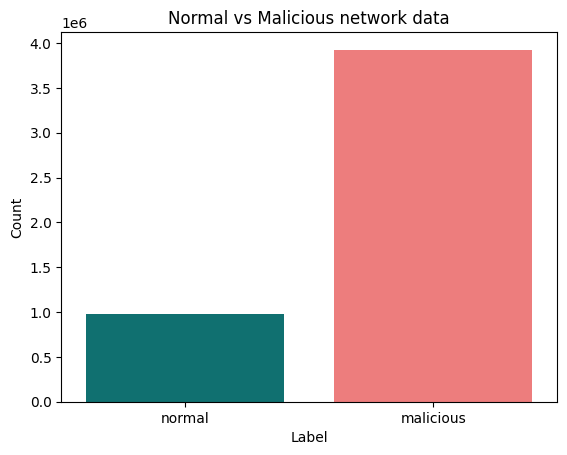

In [6]:
# bar graph to see number of normal and malicious network data

df["binary_label"] = df["label"].apply(
    lambda x: "normal" if x == "normal." else "malicious"
)

sns.countplot(
    data=df, x="binary_label", hue="binary_label", palette=["#008080", "#FF6B6B"]
)
plt.title("Normal vs Malicious network data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## 3. 🔯 Feature Engineering

-   Since the dataset has 41 features, we will use feature engineering to take 10 features.
-   This will help us create a lightweight model with less number of parameters.
-   This is done because most of the features have same entries and wouldn't hamper the performance of the model much.


In [7]:
imp_features = [
    "duration",
    "protocol_type",
    "service",
    "src_bytes",
    "dst_bytes",
    "logged_in",
    "count",
    "srv_count",
    "dst_host_count",
    "dst_host_srv_count",
    "label",
]

df_reduced = df[imp_features]

In [8]:
df_reduced.head()

,duration,protocol_type,service,src_bytes,dst_bytes,logged_in,count,srv_count,dst_host_count,dst_host_srv_count,label
0,0,tcp,http,215,45076,1,1,1,0,0,normal.
1,0,tcp,http,162,4528,1,2,2,1,1,normal.
2,0,tcp,http,236,1228,1,1,1,2,2,normal.
3,0,tcp,http,233,2032,1,2,2,3,3,normal.
4,0,tcp,http,239,486,1,3,3,4,4,normal.


In [9]:
df_reduced.shape

(4898431, 11)

## 4. 🎯 Filter only the normal data for training

-   For unsupervised learning, we have to remove the malicious data, because we have to make sure our model learns what `normal` looks like.
-   Isolation forest does not learn normal data too well. It exploits the fact that:
    -   Anomalies are rare and different, so they can be isolated with fewer random splits.
    -   Normal points are dense and similar, requiring more splits to isolate.
-   Autoencoders learn to compress and reconstruct normal data. Anomalies fail to reconstruct well.


In [10]:
df_normal = df_reduced[df_reduced["label"] == "normal."]

In [11]:
df_normal.head()

,duration,protocol_type,service,src_bytes,dst_bytes,logged_in,count,srv_count,dst_host_count,dst_host_srv_count,label
0,0,tcp,http,215,45076,1,1,1,0,0,normal.
1,0,tcp,http,162,4528,1,2,2,1,1,normal.
2,0,tcp,http,236,1228,1,1,1,2,2,normal.
3,0,tcp,http,233,2032,1,2,2,3,3,normal.
4,0,tcp,http,239,486,1,3,3,4,4,normal.


In [12]:
df_normal.shape

(972781, 11)

## 5. 🤔 Missing Values

Let's see if there are any missing values in the reduced data frame


In [13]:
df_normal.isna().values.any()

np.False_

-   Since there were no missing values, we can move forward.


## 6. 🧹 Preprocessing

-   We have to drop the target labels, because it is unsupervised learning.
-   They won't affect the learning as they are not features.
-   We have to seperate categorical and numerical columns for preprocessing.


In [14]:
X = df_normal.drop(labels=["label"], axis=1)

In [15]:
X.head()

,duration,protocol_type,service,src_bytes,dst_bytes,logged_in,count,srv_count,dst_host_count,dst_host_srv_count
0,0,tcp,http,215,45076,1,1,1,0,0
1,0,tcp,http,162,4528,1,2,2,1,1
2,0,tcp,http,236,1228,1,1,1,2,2
3,0,tcp,http,233,2032,1,2,2,3,3
4,0,tcp,http,239,486,1,3,3,4,4


In [16]:
X.shape

(972781, 10)

In [17]:
categorical_columns = X.select_dtypes(exclude=["number"]).columns
numerical_columns = X.select_dtypes(include=["number"]).columns

preprocessor = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            categorical_columns,
        ),
        ("scaler", StandardScaler(), numerical_columns),
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

## 7A. 🌲 Isolation Forest model

-   Isolation Forest is an efficient and simple algorithm used for anomaly detection.
-   It identifies outliers in large datasets by isolating them through binary partitioning.
-   There are three main features of this model:
    1. `Isolation`: This algorithm isolates the anomalies by focusing on their differences from normal data points.
    2. `Partitioning`: Data is split by randomly selecting features and using random values to partition the data.
    3. `Anomaly Score`: it measures how easilt a data point can be isolated. Points that require fewer splits to isolate are considered anomalies and assigned higher scores.
-   We are using `contamination` parameter value as `auto`.
-   Typically this threshold ranges from 0.0 to 0.5.
-   By choosing `auto`, the model will adjust it's value upon training, and we do not have to fine tune it.


In [18]:
isolation_forest_model = IsolationForest(contamination="auto", random_state=42)
isolation_forest_model.fit(X_preprocessed)

,n_estimators,100
,max_samples,'auto'
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


## 7B. 🤖 Autoencoder model

-   These are a type of neural networks that learn to compress data into a compact form and then reconstruct it to closely match the original input.
-   They consist of:
    1. `Encoder`: They capture important features by reducing dimensionality.
    2. `Decoder`: They rebuild the data from this compressed representation.
-   We are using the first input layer the same dimention as the preprocessed data.
-   After the input layer, three Dense layers are added with `ReLu` activation with dimentions as 64, 32, and 64.
-   At last a `Dense` layer is added with the same dimention as the preprocessed data with `linear` activation.
-   The model was compiled with `Adam` optimizer and `MSE` loss function for anomaly detection.


In [19]:
input_dim = X_preprocessed.shape[1]

autoencoder_model = models.Sequential(
    [
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(input_dim, activation="linear"),
    ]
)

autoencoder_model.compile(optimizer="adam", loss="mse")

In [20]:
autoencoder_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37)             │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,029 (35.27 KB)

 Trainable params: 9,029 (35.27 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [22]:
autoencoder_model.fit(
    X_preprocessed,
    X_preprocessed,
    epochs=50,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0391 - val_loss: 0.0013
Epoch 2/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0020 - val_loss: 7.6102e-04
Epoch 3/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0031 - val_loss: 8.5233e-04
Epoch 4/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0012 - val_loss: 6.6370e-04
Epoch 5/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0117 - val_loss: 7.1342e-04
Epoch 6/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0015 - val_loss: 4.9894e-04
Epoch 7/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - val_loss: 8.3124e-04
Epoch 8/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 9/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0015 - val_loss: 0.0017


## 📊 5. Evaluation on mixed test data


In [23]:
df_test = pd.read_csv("Dataset/corrected.gz", names=column_names)

X_test = df_test.drop("label", axis=1)
y_test = df_test["label"].apply(lambda x: 0 if x == "normal." else 1)

X_test_preprocessed = preprocessor.transform(X_test)

### 🌲 A. For Isolation Forest:


In [24]:
y_pred_iso = isolation_forest_model.predict(X_test_preprocessed)
y_pred_iso = [0 if i == 1 else 1 for i in y_pred_iso]

### 🤖 B. For AutoEncoder:


In [25]:
reconstructions = autoencoder_model.predict(X_test_preprocessed)
mse = tf.keras.losses.mse(X_test_preprocessed, reconstructions)

9720/9720 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [26]:
mse_np = mse.numpy()
mse_normal = mse_np[y_test == 0]
threshold = np.percentile(mse_normal, 95)
y_pred_auto = (mse_np > threshold).astype(int)

In [27]:
print("Threshold:", threshold)
print("Max MSE:", mse_np.max())
print("Any anomalies detected?", (mse_np > threshold).sum())


Threshold: 0.0005383874
Max MSE: 25.738533
Any anomalies detected? 242783


## 6. 📈 Visualize Predicted labels vs Actual labels


In [28]:
y_test_series = pd.Series(y_test, name="Actual")

# For Isolation Forest:
y_pred_iso_series = pd.Series(y_pred_iso, name="Isolation Forest")

# For AutoEncoder:
y_pred_auto_series = pd.Series(y_pred_auto, name="AutoEncoder")

In [29]:
actual_counts = y_test_series.value_counts().sort_index()

# For Isolation Forest:
predicted_iso_counts = y_pred_iso_series.value_counts().sort_index()

# For AutoEncoder:
predicted_auto_counts = y_pred_auto_series.value_counts().sort_index()

In [30]:
comparision_df = pd.DataFrame(
    {
        "Actual": y_test_series,
        "Isolation Forest": y_pred_iso_series,
        "AutoEncoder": y_pred_auto_series,
    }
)

In [31]:
comparision_df.head()

,Actual,Isolation Forest,AutoEncoder
0,0,0,0
1,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0


In [32]:
melted_df = comparision_df.melt(var_name="Model", value_name="Label")

In [33]:
melted_df.head()

,Model,Label
0,Actual,0
1,Actual,0
2,Actual,0
3,Actual,1
4,Actual,1


### i (a). Bar graph (Isolation Forest)


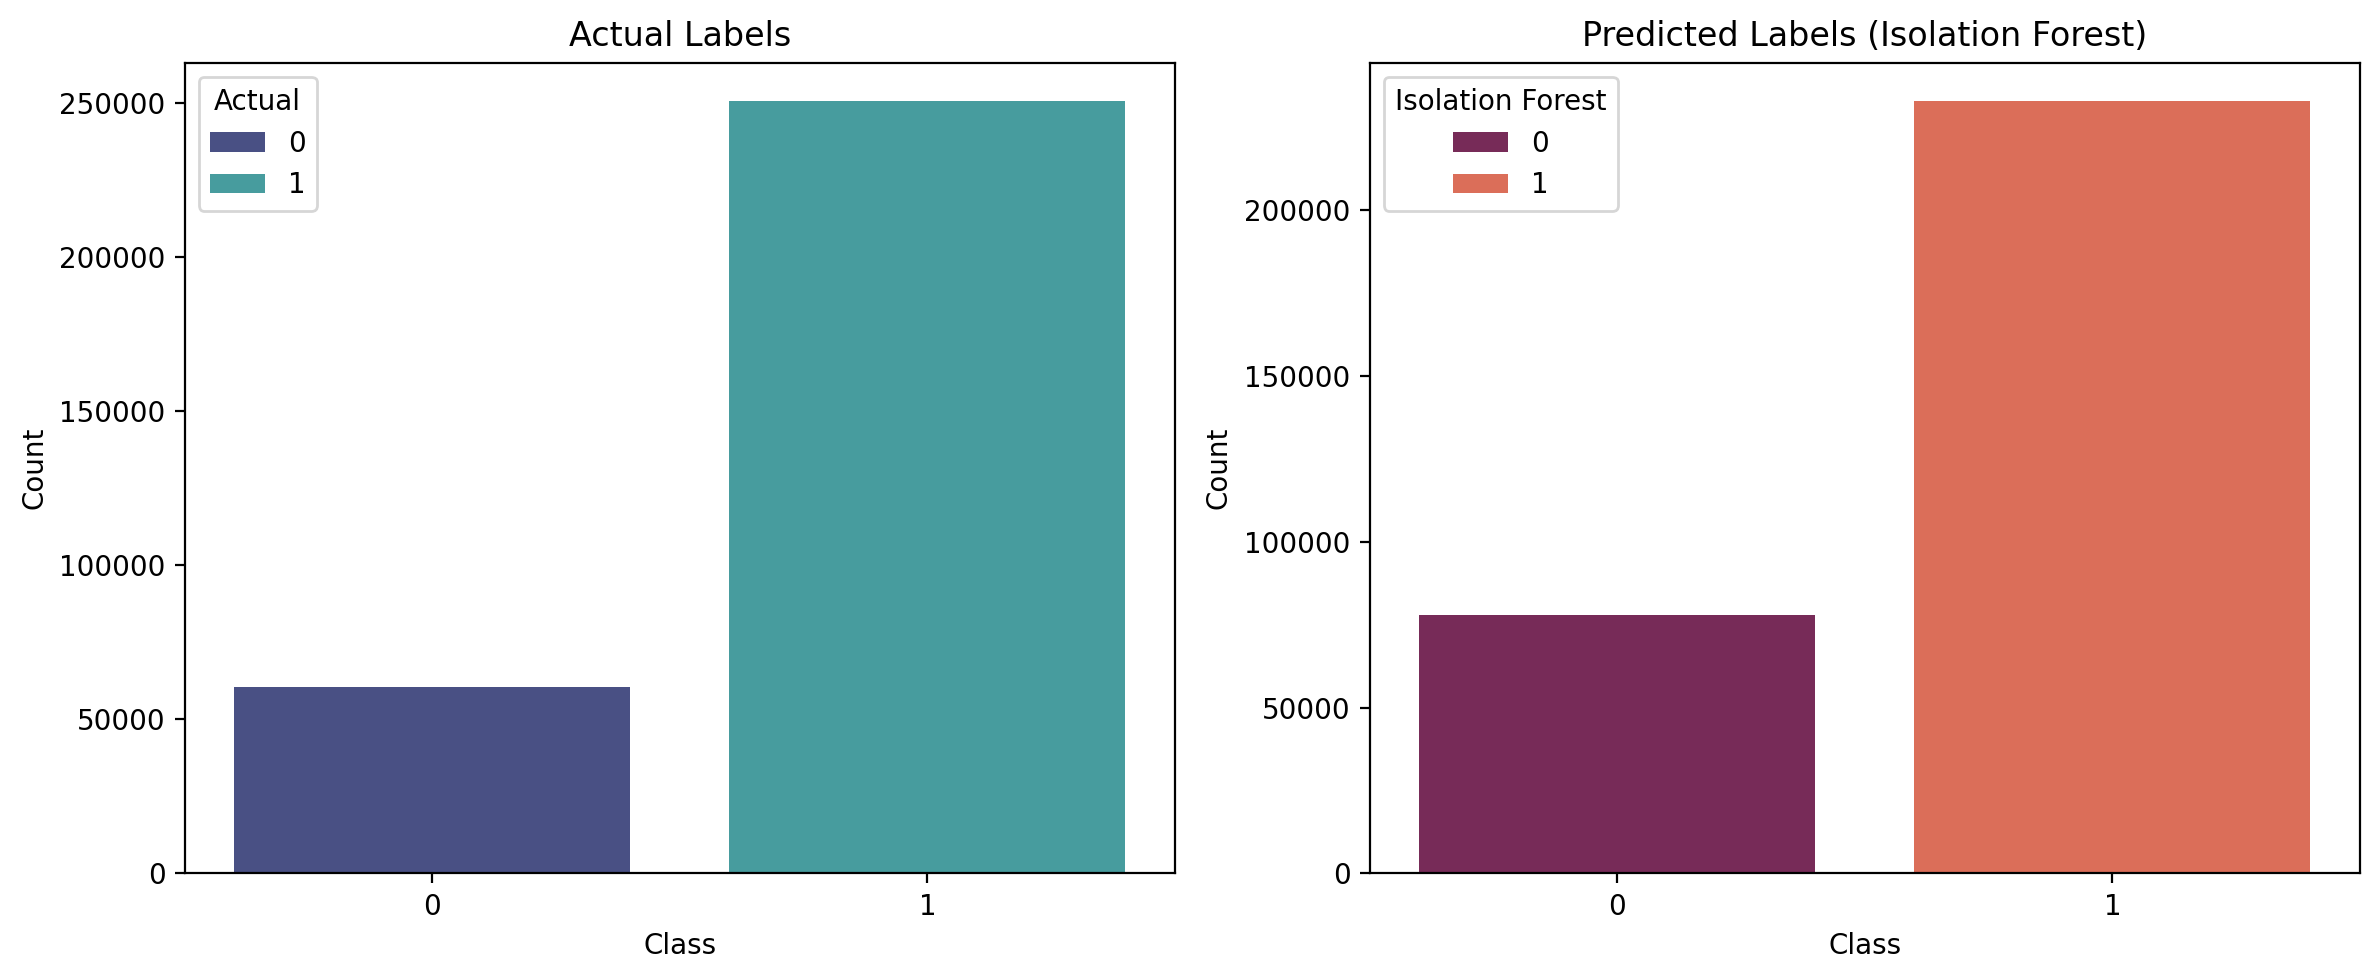

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

# actual labels
sns.barplot(
    x=actual_counts.index,
    y=actual_counts.values,
    ax=axes[0],
    palette="mako",
    hue=actual_counts.index,
)
axes[0].set_title("Actual Labels")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# predicted labels with isolation forest
sns.barplot(
    x=predicted_iso_counts.index,
    y=predicted_iso_counts.values,
    ax=axes[1],
    palette="rocket",
    hue=predicted_iso_counts.index,
)
axes[1].set_title("Predicted Labels (Isolation Forest)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

### i (b). Bar graph (AutoEncoder)


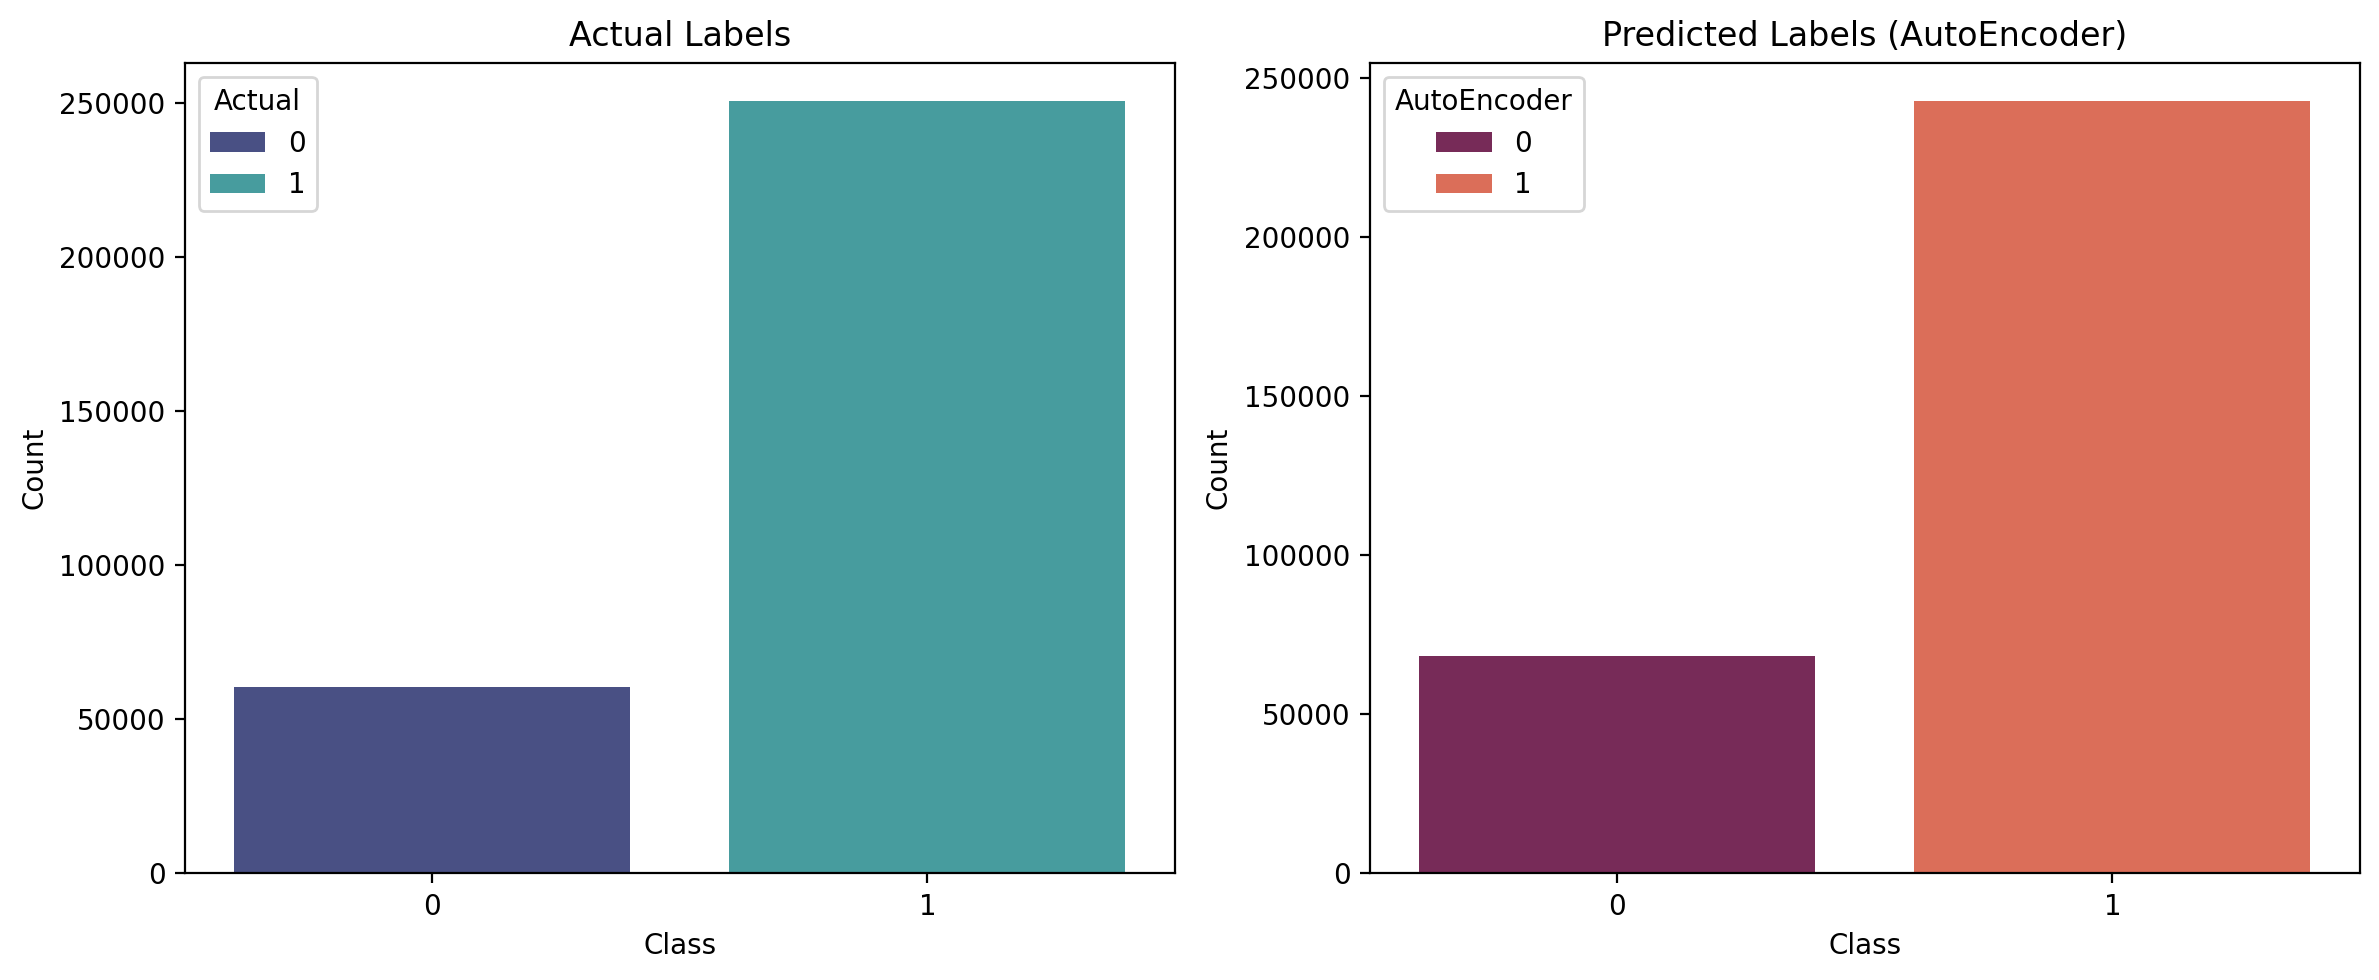

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

# actual labels
sns.barplot(
    x=actual_counts.index,
    y=actual_counts.values,
    ax=axes[0],
    palette="mako",
    hue=actual_counts.index,
)
axes[0].set_title("Actual Labels")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# predicted labels with autoencoder
sns.barplot(
    x=predicted_auto_counts.index,
    y=predicted_auto_counts.values,
    ax=axes[1],
    palette="rocket",
    hue=predicted_auto_counts.index,
)
axes[1].set_title("Predicted Labels (AutoEncoder)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

### ii. Count Plot


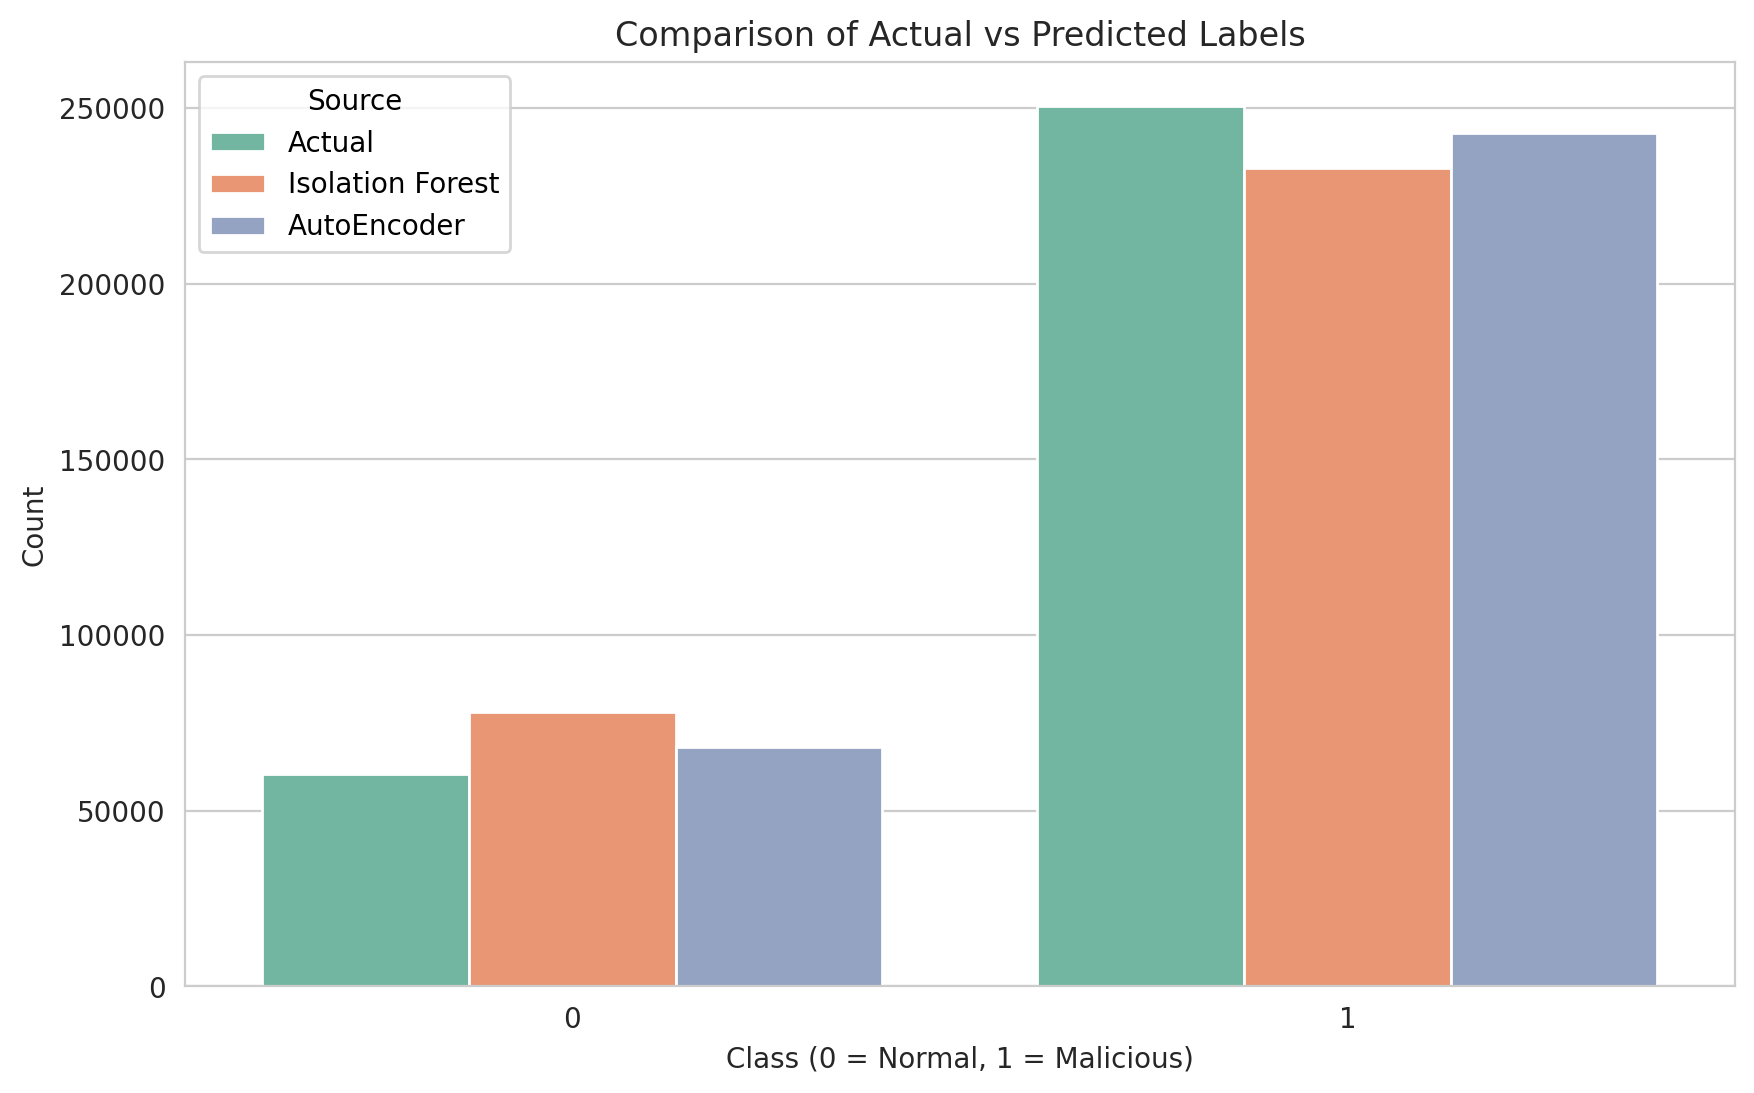

In [36]:
plt.figure(figsize=(10, 6), dpi=200)

with sns.axes_style("whitegrid"):
    sns.countplot(data=melted_df, x="Label", hue="Model", palette="Set2")

plt.title("Comparison of Actual vs Predicted Labels")
plt.xlabel("Class (0 = Normal, 1 = Malicious)")
plt.ylabel("Count")
plt.legend(title="Source")
plt.show()

## 7. 📈 Evaluation with Metrics


### i. ✔️ Classification report


In [37]:
# for isolation forest model

class_report_iso = classification_report(y_test_series, y_pred_iso_series)
print(class_report_iso)

              precision    recall  f1-score   support

           0       0.72      0.92      0.81     60593
           1       0.98      0.91      0.94    250436

    accuracy                           0.91    311029
   macro avg       0.85      0.92      0.88    311029
weighted avg       0.93      0.91      0.92    311029



In [38]:
# for autoencoder model

class_report_auto = classification_report(y_test_series, y_pred_auto_series)
print(class_report_auto)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     60593
           1       0.99      0.96      0.97    250436

    accuracy                           0.96    311029
   macro avg       0.92      0.95      0.93    311029
weighted avg       0.96      0.96      0.96    311029



### ii. 😵 Confusion matrix


In [39]:
# for isolation forest model

cm_iso = confusion_matrix(y_test_series, y_pred_iso_series)
print(cm_iso)

[[ 55990   4603]
 [ 22105 228331]]


In [40]:
# for autoencoder model

cm_auto = confusion_matrix(y_test_series, y_pred_auto_series)
print(cm_auto)

[[ 57563   3030]
 [ 10683 239753]]


## 8. 🛞 Visualize with Confusion matrix Heatmap


### i (a). Isolation Forest


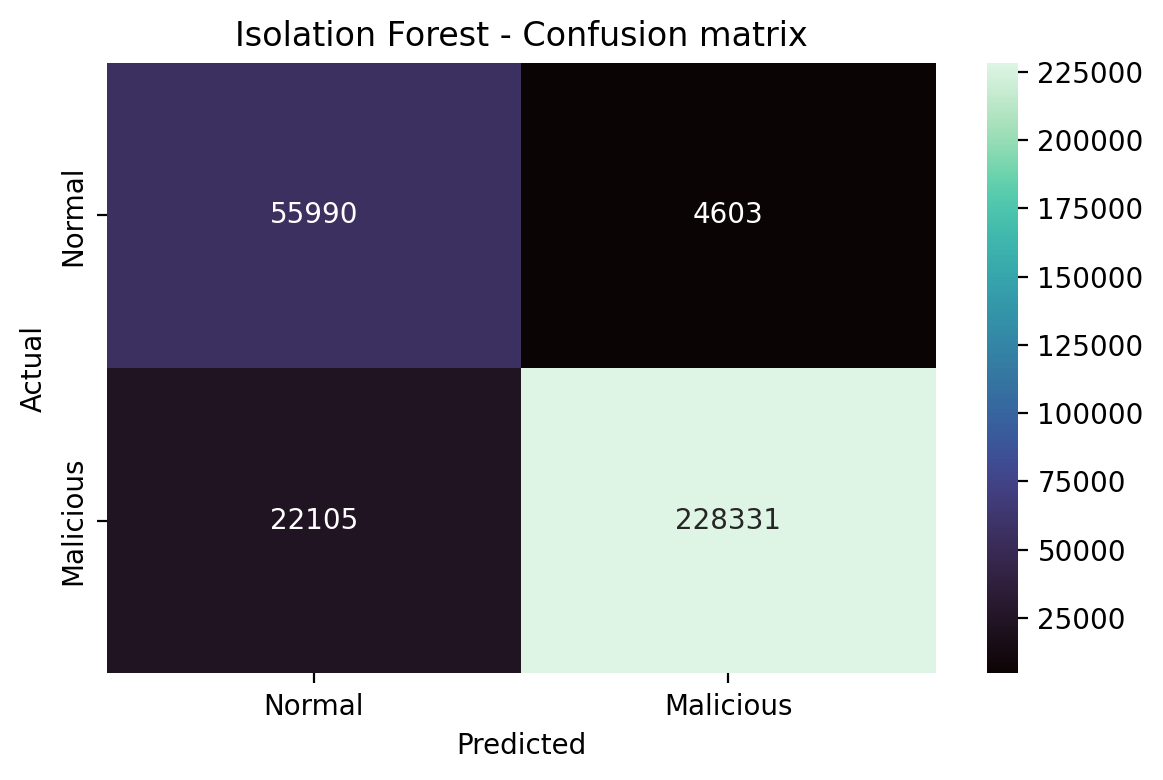

In [41]:
plt.figure(figsize=(6, 4), dpi=200)

sns.heatmap(
    cm_iso,
    annot=True,
    fmt="d",
    cmap="mako",
    yticklabels=["Normal", "Malicious"],
    xticklabels=["Normal", "Malicious"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Isolation Forest - Confusion matrix")
plt.tight_layout()
plt.show()

### i (b). AutoEncoder


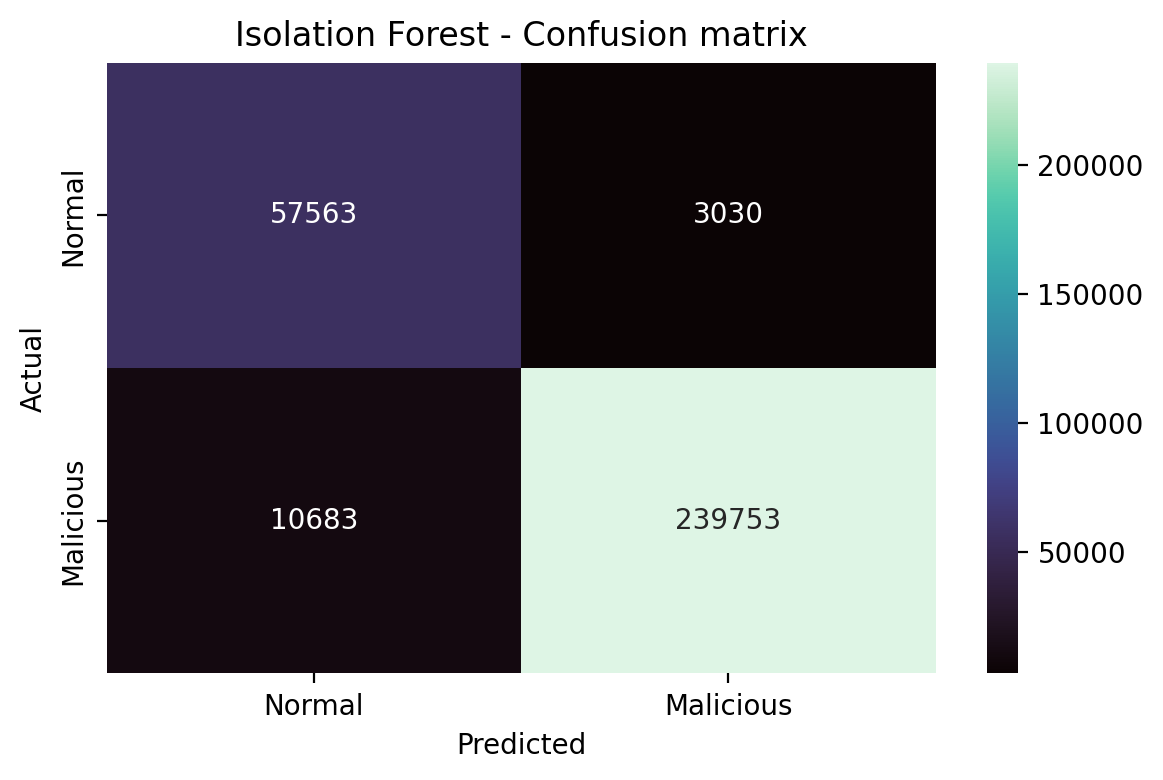

In [42]:
plt.figure(figsize=(6, 4), dpi=200)

sns.heatmap(
    cm_auto,
    annot=True,
    fmt="d",
    cmap="mako",
    yticklabels=["Normal", "Malicious"],
    xticklabels=["Normal", "Malicious"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Isolation Forest - Confusion matrix")
plt.tight_layout()
plt.show()

## ⬇️ 9. Save the models and preprocessor


In [44]:
pipeline = {
    "preprocessor": preprocessor,
    "isolation_forest_model": isolation_forest_model,
    "autoencoder_model": autoencoder_model,
    "autoencoder_threshold": threshold,
}

with open("models.pkl", "wb") as f:
    cloudpickle.dump(pipeline, f)